# Итоговый отчет

## Введение


Цель проекта:

Создать модель нейронной сети, которая будет определять эмоции человека на фотографии, и успешно интегрировать ее в телеграм бота.

## Отчет №1 Сбор данных



**Сбор данных**

На первом этапе была выполнена задача по сбору большого набора фотографий людей с различными выражениями лиц, представляющими разные эмоции.

**Классификация данных**

Все собранные фотографии были классифицированы по следующим категориям эмоций:

Грусть

Радость

Гнев

По итогам этапа была успешно сформирована и классифицирована база данных, включающая три ключевые эмоции: Грусть, Радость и Гнев.

Общая база данных получилась на 265 фотографий. Фотографии в формате .jpg

Фотографии взяты из открытого источника: https://www.kaggle.com/datasets/sanidhyak/human-face-emotions/data

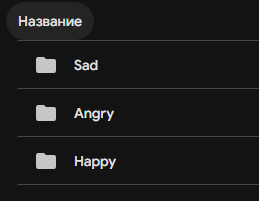

## Отчет №2 Анализ, предобработка и разделение данных


Цели этапа:
**Текст, выделенный полужирным шрифтом**
Выполнить анализ и предобработку собранных данных, включая такие операции, как масштабирование, обрезка и нормализация изображений.
Разделить данные на три выборки: обучающую, валидационную и тестовую, для обеспечения корректного обучения и оценки модели.

**Результаты выполнения:**

Все изображения были предобработаны следующим образом:

1) Нормализация значений пикселей для согласования данных.

2) Обрезка и масштабирование изображений для приведения их к единому размеру и формату.

**Проведено разделение данных с использованием следующих пропорций:**

Обучающая выборка: 60%

Валидационная выборка: 20%

Тестовая выборка: 20%

Для корректного разделения данных было использовано случайное перемешивание, что позволило равномерно распределить изображения по классам (Грусть, Радость, Гнев) в каждой выборке. Это минимизирует вероятность смещения данных и обеспечивает надежную оценку производительности модели на независимых наборах данных.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ИИ/дб'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from PIL import Image

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
random_path = '/content/drive/MyDrive/ИИ/дб/Happy/05-12-21-happy-people.jpg'
Image.open(random_path)

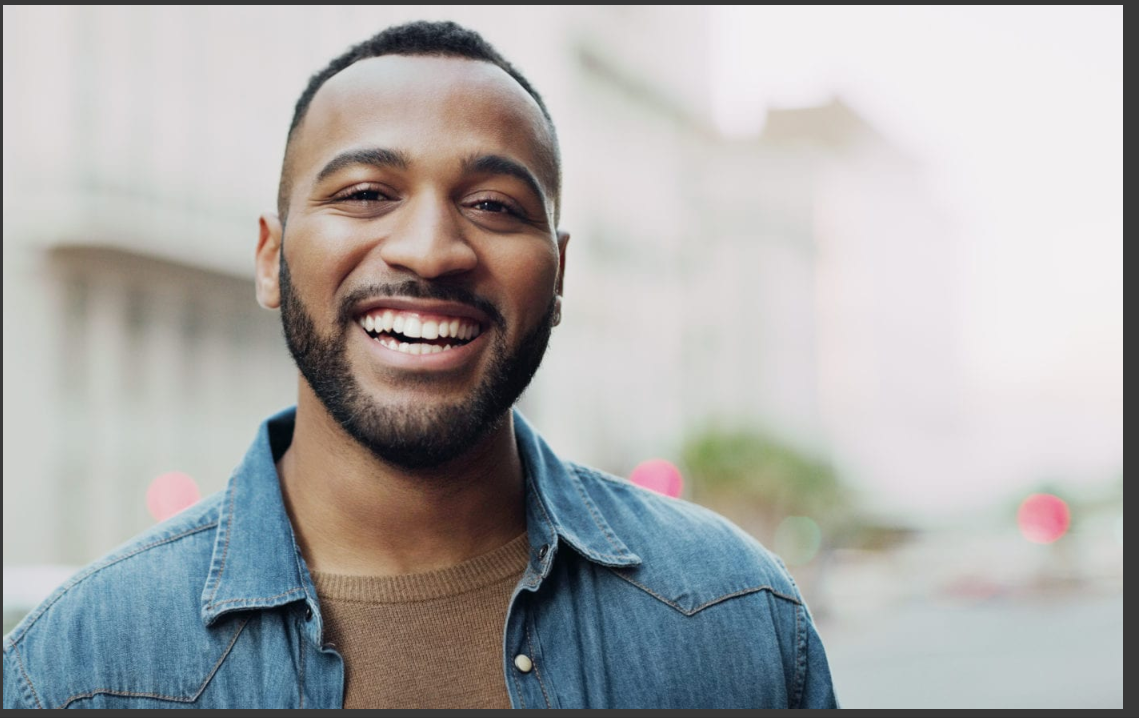

In [ ]:
PATH = '/content/drive/MyDrive/ИИ/дб'

img_dir = Path(PATH)
files = list(img_dir.glob('**/*.jpg'))

In [ ]:
# For illustration purpose
print(os.path.split(files[0]))
print(os.path.split(files[0])[0])
print(os.path.split(files[0])[0].split('/')[-1])

label = list(map(lambda x: os.path.split(x)[0].split('/')[-1], files))

In [ ]:
paths = pd.Series(files,name='Path').astype(str)
labels = pd.Series(label,name='Label')
df = pd.concat([paths,labels],axis=1)

display(df.head())
display(df.tail())
display(df.shape)

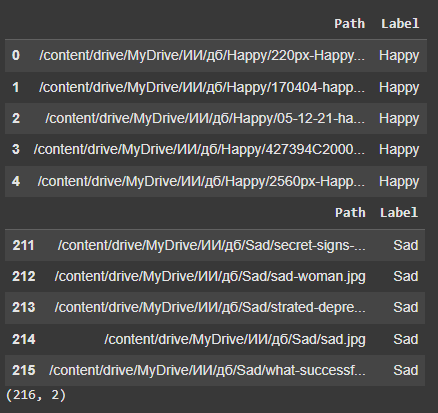

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(df.Path, df.Label, test_size = 0.2, shuffle = True, random_state = 42)
display(X_tr)
display(y_tr)

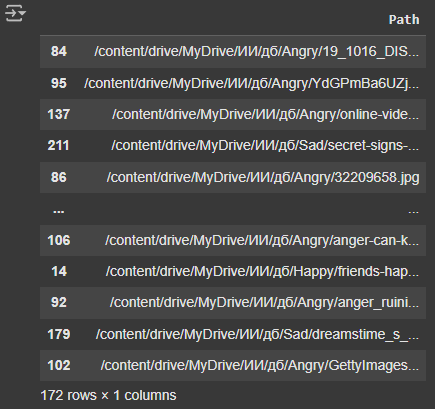

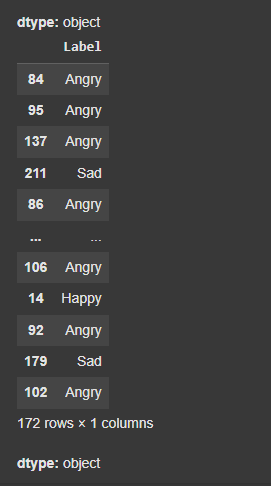

In [ ]:
df.Label.value_counts()

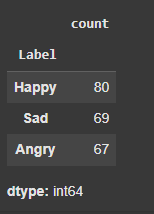

In [ ]:
plt.pie(df.Label.value_counts().values, labels=df.Label.value_counts().index, autopct='%1.1f%%')
plt.legend(loc = 'lower left')
plt.title('Percentage Breakdown of Labels')
plt.show();

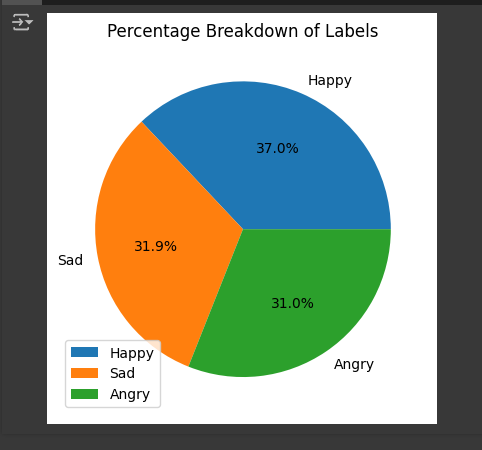

In [ ]:
# a random example
import random
random_paths = X_tr.sample(10)
random_img = [plt.imread(x) for x in random_paths]
random_img_dim = [x.shape for x in random_img]
random_img_dim

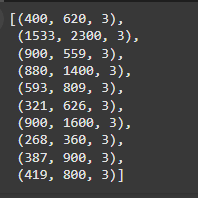

In [ ]:
class_names = np.array(sorted([item.name for item in img_dir.glob('*')]))
class_names

In [ ]:
tr, val = pd.concat([X_tr, y_tr], axis = 1).reset_index(drop = True), pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
display(tr.head())
display(val.head())

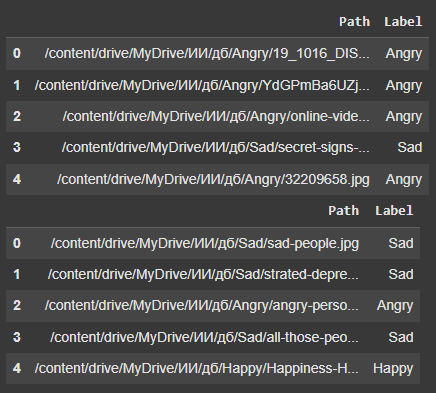

In [ ]:
label_to_int = {label: i for i, label in enumerate(tr.Label.unique())}
tr.Label = tr.Label.map(label_to_int)
val.Label = val.Label.map(label_to_int)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.df.loc[idx, 'Path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'Label']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # scales the image's pixel intensities to the range [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train = CustomImageDataset(tr, transform = transform)
valid = CustomImageDataset(val, transform = transform)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid, batch_size=BATCH_SIZE)

In [ ]:
type(train_loader)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

## Отчет №3 Построение модели

**Цели этапа:**

Определить преимущества архитектуры EfficientNet_B0.

Построить модель, указав количество слоев и параметры модели.

**Архитектура:**

Архитектура EfficientNet_B0 представляет собой современный подход к обработке изображений, который оптимизирует баланс между точностью модели и ее вычислительной эффективностью. Ключевой особенностью является использование техники compound scaling, которая масштабирует глубину, ширину и разрешение сети для достижения наилучшей производительности.

**Компоненты архитектуры:**

Base Network: EfficientNet_B0 включает несколько мобильных сверточных блоков (Mobile Inverted Bottleneck), использующих механизмы свертки и внимания.

Слои Global Average Pooling: Они преобразуют пространственные признаки в компактные векторные представления.

Classification Head: Последние слои сети предназначены для классификации и построения предсказаний.

**Параметры модели:**

model_str: EfficientNet_B0 – предварительно обученная модель на ImageNet, адаптированная для текущей задачи.

num_labels: Определяется автоматически, в данном случае — 3 (Грусть, Радость, Гнев).

num_train_epochs: Количество эпох обучения.

learning_rate: Скорость обучения, подбирается экспериментально.

per_device_train_batch_size: Размер батча для обучения.

per_device_eval_batch_size: Размер батча для оценки.

Архитектура EfficientNet_B0 была выбрана за ее вычислительную эффективность и способность достигать высокой точности при минимальных ресурсах.

Построем две модели, чтобы доказать, что модель с EfficientNet_B0 эффективнее


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(5, 5, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(5, 5, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(5*56*56, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim =1)


In [ ]:
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = ConvNet()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
import torchmetrics
accuracy_metric = torchmetrics.Accuracy(task = 'multiclass', num_classes = 3).to(device)

Модель с EfficientNet_B0


In [ ]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

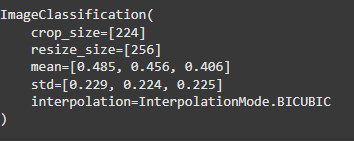

In [ ]:
train = CustomImageDataset(tr, transform = auto_transforms)
valid = CustomImageDataset(val, transform = auto_transforms)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid, batch_size=BATCH_SIZE)

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True)).to(device)

In [ ]:
for param in model.features[8].parameters():
    param.requires_grad = True

In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

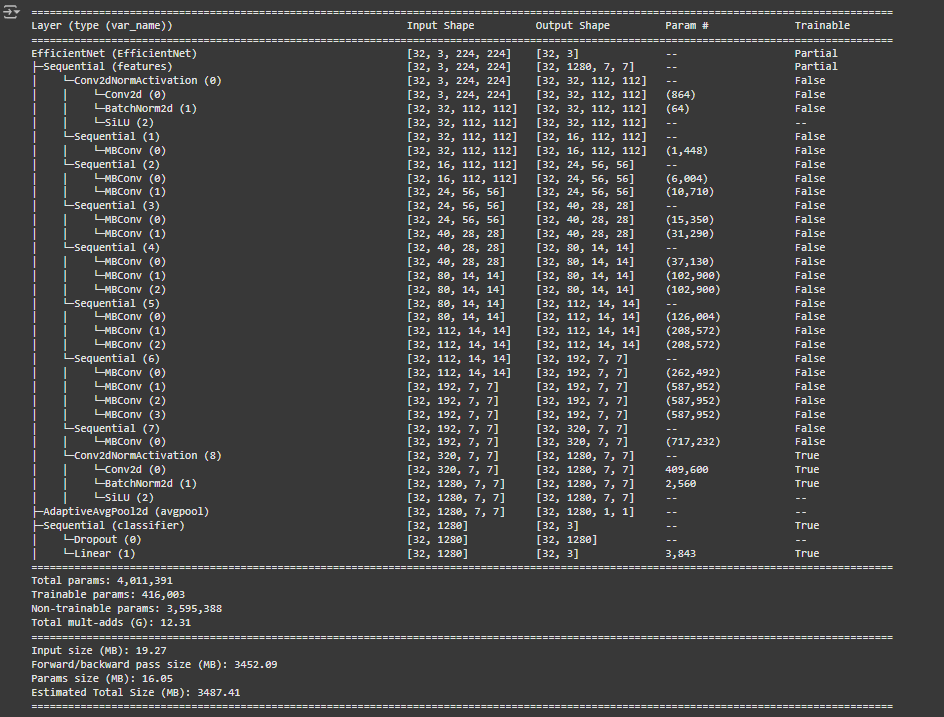

На следующем этапе докажем, что точность EfficientNet_B0 выше

## Отчет №4 Обучение модели


Цели этапа:

1) Обучить модель на обучающей выборке, используя алгоритмы глубокого обучения.

2) Оптимизировать гиперпараметры модели для достижения высокой точности распознавания.

3) Использовать валидационную выборку для контроля качества модели и предотвращения переобучения.

In [ ]:
def train_step(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         criterion: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         accuracy_fn: torchmetrics.Accuracy,
         device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.train()
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        preds = logits.argmax(dim = 1)
        train_acc += accuracy_fn(preds, y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              criterion: torch.nn.Module,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_logits = model(X)

            # 2. Calculate loss and accuracy
            test_loss += criterion(test_logits, y)
            preds = test_logits.argmax(dim = 1)
            test_acc += accuracy_fn(preds, y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        accuracy_fn=accuracy_metric
    )
    test_step(data_loader=val_loader,
        model=model,
        criterion=criterion,
        accuracy_fn=accuracy_metric
    )

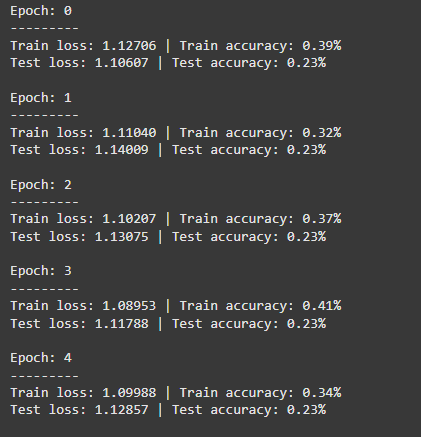

Данная модель показала низкую точность и высокие потери. Поэтому используем предобученную модель EfficientNet_B0.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        accuracy_fn=accuracy_metric
    )
    test_step(data_loader=val_loader,
        model=model,
        criterion=criterion,
        accuracy_fn=accuracy_metric
    )

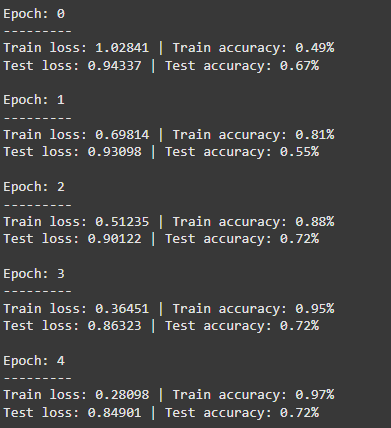

Точность этой модели в разы больше, чем предыдущей.

## Отчет №5

## Отчет №6 Создание интерфейса


Цели этапа:

1) Разработать пользовательский интерфейс в Telegram для загрузки фотографий и запросов к искусственному интеллекту.

2) Интегрировать модель искусственного интеллекта в интерфейс Telegram.

https://t.me/BotEmote_bot

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, CallbackContext
from PIL import Image
import io
import nest_asyncio
from telegram import Bot

In [ ]:
nest_asyncio.apply()

model = torch.load('/content/drive/MyDrive/ИИ/V3/efficientnet_b0_full.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()

unique_labels = ["Злость", "Грусть", "Счастье"]

def process_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

API_TOKEN = "8100399006:AAH5NnFdFmyjdlDhUnG8gqICewcUOpLaclQ"
bot = Bot(token=API_TOKEN)

async def start(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text("Привет! Я бот для классификации эмоций на изображениях. Отправь мне изображение, и я попробую его классифицировать!")

async def handle_image(update: Update, context: CallbackContext) -> None:
    photo = update.message.photo[-1]
    file_info = await bot.get_file(photo.file_id)
    downloaded_file = await file_info.download_as_bytearray()
    image = Image.open(io.BytesIO(downloaded_file))
    processed_image = process_image(image)
    processed_image = processed_image.to(device)

    with torch.no_grad():
        predictions = model(processed_image)
        probabilities = F.softmax(predictions, dim=1)
        predicted_index = torch.argmax(probabilities, dim=1).item()
        predicted_label = unique_labels[predicted_index]
        confidence = probabilities[0][predicted_index].item()

    await update.message.reply_text(f"Класс: {predicted_label}")

def main():
    application = Application.builder().token(API_TOKEN).build()
    application.add_handler(CommandHandler("start", start))
    application.add_handler(MessageHandler(filters.PHOTO, handle_image))
    application.run_polling()

if __name__ == "__main__":
    main()

Результат работы:


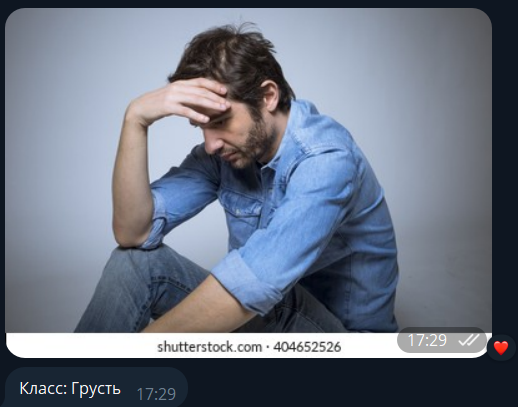

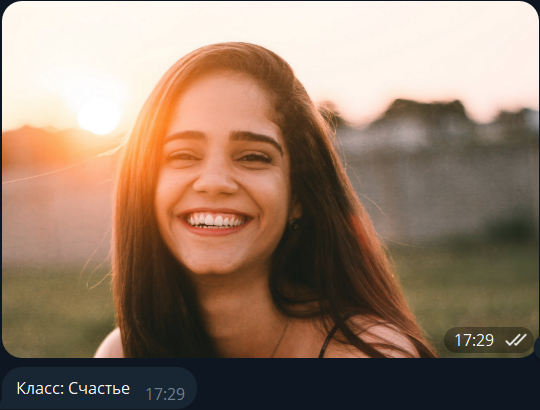

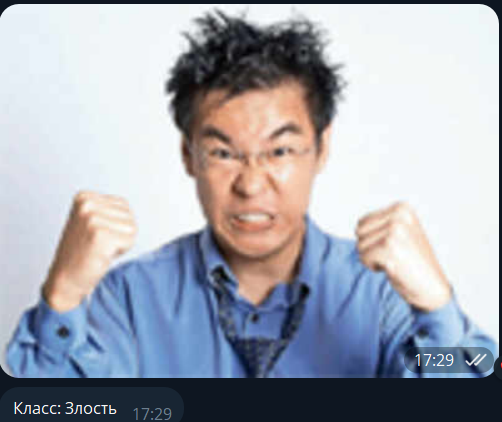

Модель была успешно интегрированна в бота.


## Вывод

Цельи проекта успешно достигнута. Модель хорошо определяет эмоции человека:

Грусть

Счастье

Злость

А так же, модель успешно интегрированна в телеграм бота